In [1]:
import os
import socket

hostname = socket.gethostname()
if hostname == "hctlrds":
    COCO_FOLDER = "/mnt/ssd2/xin/data/coco/"
elif hostname == "Chen-Mac-mini.local":
    COCO_FOLDER = "/Volumes/Storage/Datasets/coco"
else:
    raise NotImplementedError

# distrotion process

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pathlib import Path


from utils import (
    load_camera_params_from_cfg_file,
    ltwh2xyxy,
    xyxy2ltwh,
    annotate_image,
    display_image,
    get_image_path,
    load_target,
    undistort_mesh,
    distort_image,
    get_bounding_rect,
    invert_map,
)

In [3]:
camera_cfg = (
    "cfg/camera/2024_8_20_11_38_34_720x960_4149298_2024_08_02_A5PRT9_ip_72_test.cfg"
)

cam_matrix, dist_vec = load_camera_params_from_cfg_file(camera_cfg)
K = np.array(cam_matrix)
D = np.array(dist_vec)

In [4]:
coco_folder = COCO_FOLDER
split = "val2017"
root = os.path.join(coco_folder, split)
annFile = os.path.join(coco_folder, "annotations", f"instances_{split}.json")

In [8]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.93s)
creating index...
index created!


In [9]:
ids = sorted(coco.getImgIds())
id = 477805

img_path = get_image_path(coco, id)
targets = load_target(coco, id)

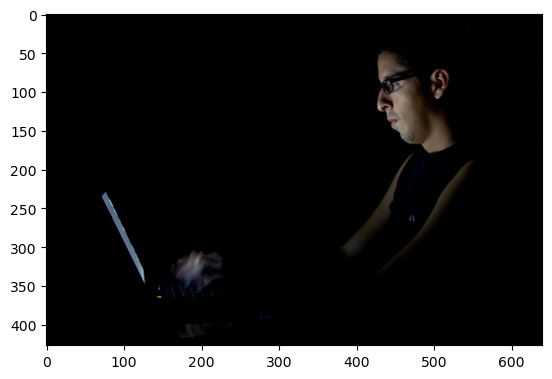

In [10]:
img_path = os.path.join(root, img_path)
img = cv2.imread(img_path)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [11]:
bboxes_xyxy = []
category_ids = []
for target in targets:
    bbox = np.array(target["bbox"])
    bbox = ltwh2xyxy(bbox)
    bboxes_xyxy.append(bbox)
    category_ids.append(target["category_id"])
bboxes_xyxy = np.array(bboxes_xyxy)
category_ids = np.array(category_ids)
confs = None  # gt
category_id_to_name = {k: v["name"] for k, v in coco.cats.items()}

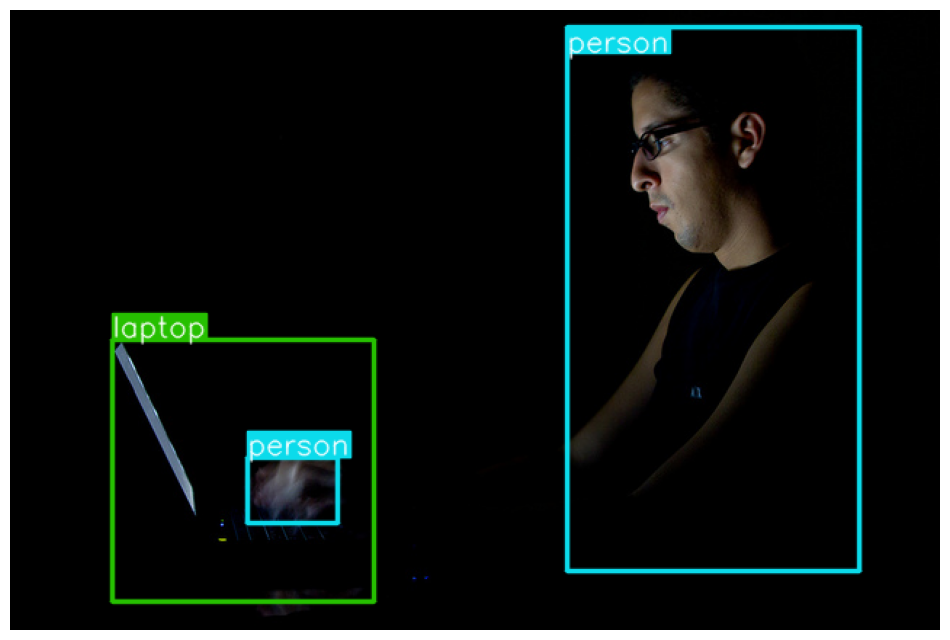

In [12]:
display_image(
    annotate_image(
        img[:, :, ::-1], bboxes_xyxy, category_ids, confs, category_id_to_name
    )
)

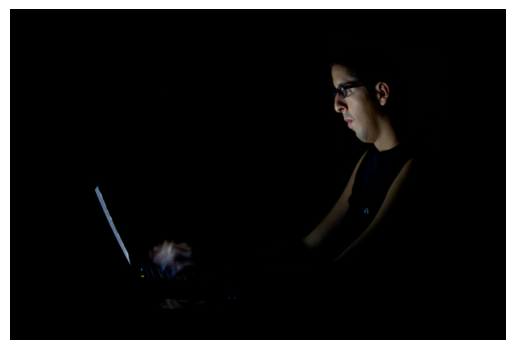

In [13]:
img = cv2.imread(img_path)
u, v = undistort_mesh(img, K, D)

distorted_img = distort_image(img, u, v)

plt.imshow(cv2.cvtColor(distorted_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [14]:
# stack u,v in third dim
uv = np.stack([u, v], axis=-1)
uv_inverse = invert_map(uv)
uv_inverse.shape

(427, 640, 2)

In [15]:
distorted_bboxes_xyxy = []
for bbox in bboxes_xyxy:
    x1, y1, x2, y2 = bbox.astype(int)
    distorted_bboxes_xyxy.append(
        np.concatenate((uv_inverse[y1, x1], uv_inverse[y2, x2]))
    )
distorted_bboxes_xyxy = np.array(distorted_bboxes_xyxy)

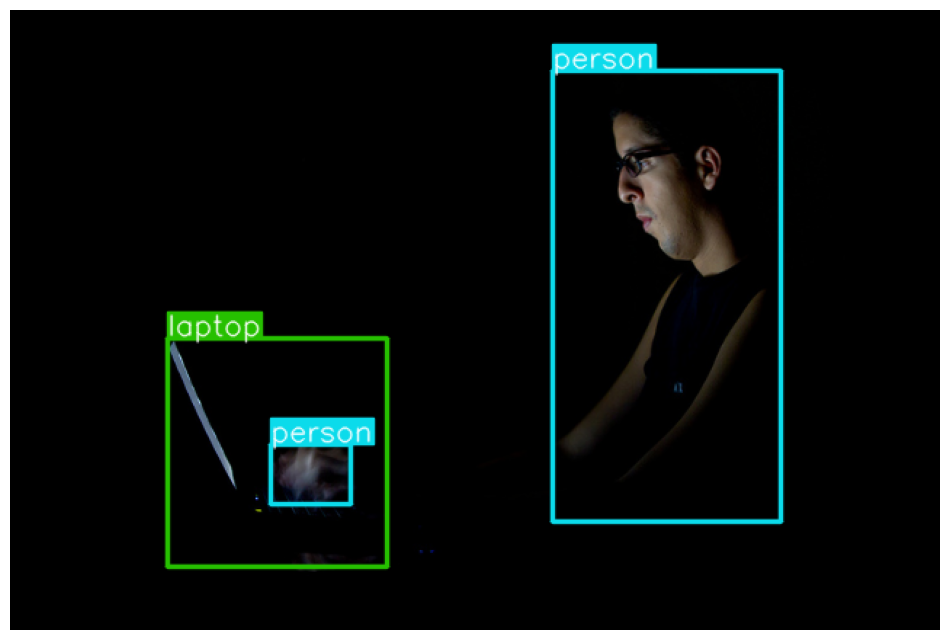

In [16]:
display_image(
    annotate_image(
        distorted_img[:, :, ::-1],
        distorted_bboxes_xyxy,
        category_ids,
        confs,
        category_id_to_name,
    )
)

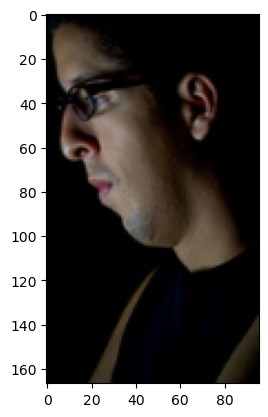

In [17]:
# get rid of the black edges of distorted_img

x, y, w, h = get_bounding_rect(distorted_img)
cropped_distorted_image = distorted_img[y : y + h, x : x + w]
plt.imshow(cv2.cvtColor(cropped_distorted_image, cv2.COLOR_BGR2RGB))

In [18]:
cropped_distorted_bboxes_xyxy = []
for bbox in distorted_bboxes_xyxy:
    bbox = bbox - np.array([x, y, x, y])
    cropped_distorted_bboxes_xyxy.append(bbox)
cropped_distorted_bboxes_xyxy = np.array(cropped_distorted_bboxes_xyxy)

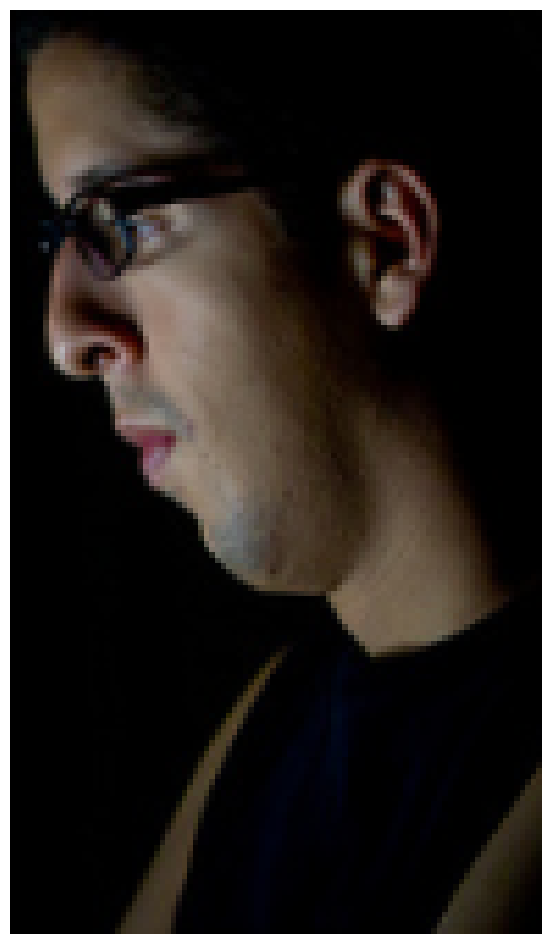

In [19]:
display_image(
    annotate_image(
        cropped_distorted_image[:, :, ::-1],
        cropped_distorted_bboxes_xyxy,
        category_ids,
        confs,
        category_id_to_name,
    )
)

# load from coco_distorted

In [25]:
coco_folder = COCO_FOLDER
split = "val2017"  # TODO

coco_distorted_folder = coco_folder.replace("/coco/", "/coco_distorted/")
root_coco_distorted = os.path.join(coco_distorted_folder, split)
annFile_coco_distorted = os.path.join(
    coco_distorted_folder, "annotations", f"instances_{split}.json"
)

coco = COCO(annFile_coco_distorted)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [26]:
img_path

'/mnt/ssd2/xin/data/coco_distorted/val2017/000000000139.jpg'

In [27]:
ids = sorted(coco.getImgIds())
id = 477805

img_path = os.path.join(root_coco_distorted, get_image_path(coco, id))
img = cv2.imread(img_path)

In [28]:
targets = load_target(coco, id)

bboxes_xyxy = []
category_ids = []
for target in targets:
    bbox = np.array(target["bbox"])
    bbox = ltwh2xyxy(bbox)
    bboxes_xyxy.append(bbox)
    category_ids.append(target["category_id"])
bboxes_xyxy = np.array(bboxes_xyxy)
category_ids = np.array(category_ids)
confs = None  # gt
category_id_to_name = {k: v["name"] for k, v in coco.cats.items()}

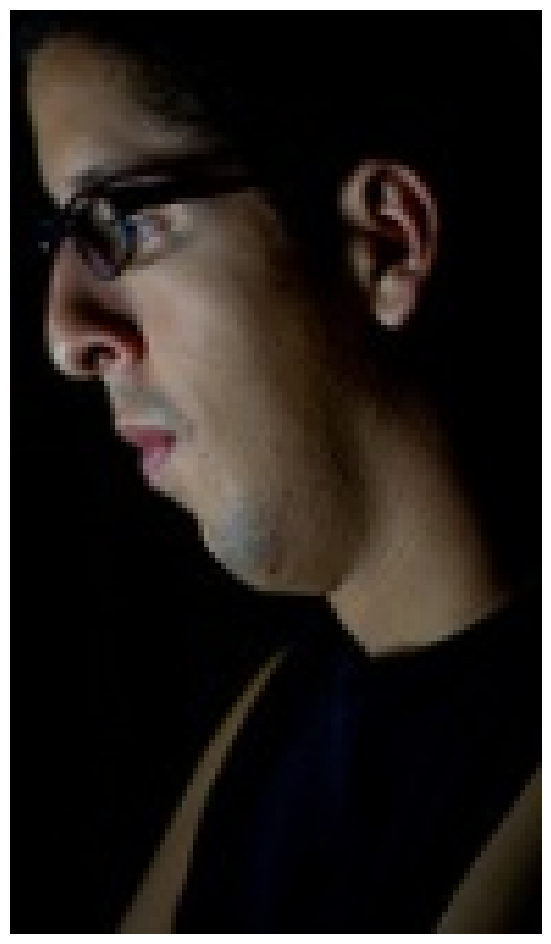

In [29]:
display_image(
    annotate_image(
        img[:, :, ::-1], bboxes_xyxy, category_ids, confs, category_id_to_name
    )
)